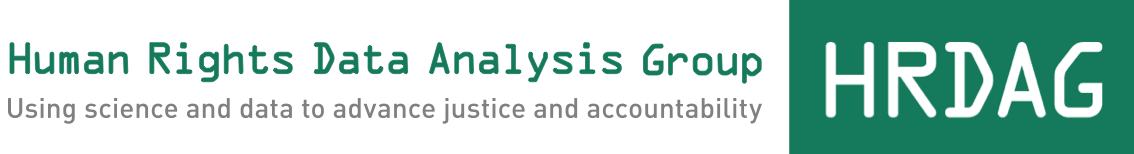

In [1]:
from IPython.display import Image
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from ast import literal_eval


Image(filename='../imgs/banner.png')

# Table of Contents
1. [Introduction](#intro)
2. [Analysis Types](#types)
3. [Results](#results)
4. [Addressing Precision and F1 Scores](#scores)
5. [Key Insight](#insights)
6. [Additional Insights](#xtra)
7. [Feature Importance Analysis](#importance)
8. [Conclusions](#conclusions)
9. [Resources](#links)

In [2]:
# import tables
def read_format(csvf):
    df = pd.read_csv(csvf)
    df['proportion_matched'] = df.percentage_matched.apply(lambda x: round(x/100, 2))
    metrics = ['precision', 'recall', 'f1_score', 'f_beta_score']
    for metric in metrics:
        df[metric] = df[metric].apply(lambda x: round(x, 2))
    return df

# PROPOSED BUILD (removes whitespace and some repetition)
# NOTE: `read_format()` was not used originally but I've added it
files = {
    # allContext (iterate over all of the content within the document with one api call)
    'fullcontext_sonnet': '../data/allContext/results_claude-3-5-sonnet-20240620.csv',
    'fullcontext_haiku': '../data/allContext/results_claude-3-haiku-20240307.csv',
    'fullcontext_opus': '../data/allContext/results_claude-3-opus-20240229.csv',
    'fullcontext_nemo': '../data/allContext/results_open-mistral-nemo.csv',

    # AllPages (iterate over each page with one api call per page)
    'allpages_haiku': '../data/allPages/results_claude-3-haiku-20240307.csv',
    'allpages_sonnet': '../data/allPages/results_claude-3-5-sonnet-20240620.csv',
    'allpages_mixtral_7b': '../data/allPages/Mixtral-8x7B-Instruct-v0.1.csv',
    'allpages_mixtral_22b': '../data/allPages/Mixtral-8x22B-Instruct-v0.1.csv',

    # use Named Entity Recognition (NER) to calculate the number of entities on each page as a preprocessing step.
    # It then processes the document in three separate iterations.
    # In each iteration, it focuses on different top fractions of pages containing the most entities:
    # first the top 1/4th, then the top 1/2, and finally the top 3/4ths of the document.
    # For each fraction, the script identifies the pages with the highest number of entities and then iterates over each of those pages,
    # similar to the allPages script, to extract the entities.
    'ner_25_haiku': '../data/ner/results_claude-3-haiku-20240307-25per.csv',
    'ner_50_haiku': '../data/ner/results_claude-3-haiku-20240307-50per.csv',
    'ner_75_haiku': '../data/ner/results_claude-3-haiku-20240307-75per.csv',
    'ner_25_sonnet': '../data/ner/results_claude-3-5-sonnet-20240620-25per.csv',
    'ner_50_sonnet': '../data/ner/results_claude-3-5-sonnet-20240620-50per.csv',
    'ner_75_sonnet': '../data/ner/results_claude-3-5-sonnet-20240620-75per.csv',
    'ner_25_mixtral_7b': '../data/ner/Mixtral-8x7B-Instruct-v0.1-25per.csv',
    'ner_50_mixtral_7b': '../data/ner/Mixtral-8x7B-Instruct-v0.1-50per.csv',
    'ner_75_mixtral_7b': '../data/ner/Mixtral-8x7B-Instruct-v0.1-75per.csv',
    'ner_25_mixtral_22b': '../data/ner/Mixtral-8x22B-Instruct-v0.1-25per.csv',
    'ner_50_mixtral_22b': '../data/ner/Mixtral-8x22B-Instruct-v0.1-50per.csv',
    'ner_75_mixtral_22b': '../data/ner/Mixtral-8x22B-Instruct-v0.1-75per.csv',
    # Experimental vision model results
    'haiku_vision_allpages': '../data/Vision/results_claude-3-haiku-20240307.csv',
    'sonnet_vision_allpages': '../data/Vision/results_claude-3-5-sonnet-20240620.csv',
}
dfs = []
for label, path in files.items():
    df = read_format(csvf=path)
    df['analysis_type'] = label
    dfs.append(df)
full = pd.concat(dfs)
full = full.drop(columns=[
    col for col in full.columns
    if ('unnamed' in col.lower()) | (('file' in col.lower()) & ('name' in col.lower()))
    ], errors='ignore')
full = full.rename(columns={"total_ground_truth": "n_entities"})
frozen = pd.read_parquet("../data/frozen/results.parquet")
assert full.equals(frozen), f"Results data do not match frozen/expected data."
assert (df.proportion_matched == df.recall).all()

# minor formatting of results
index = ['model', 'analysis_type',]
maincols = [
    'filetype',
    'token_count', 'n_entities',
    'true_positives', 'false_positives',
    'recall','precision', 'f1_score', 'f_beta_score',
    'matched_names', 'unmatched_names',
]
main_windex = index + maincols
df = full[main_windex]
df_names = df.copy()

# Introduction <a class="anchor" id="intro"></a>

<br>

In the previous chapter of this series, we explored the application of large language models (LLMs) for structured information extraction from wrongful conviction case files using retrieval augmented generation (RAG). However, recent advancements in LLM technology have necessitated a re-evaluation of our information extraction pipeline. Models like Gemini 1.5 Pro with its one million token context window and Claude 3 Opus/Sonnet/Haiku with a 200k context window now allow entire documents to fit within a single context window, potentially eliminating the need for retrieving specific document pages. Furthermore, the emergence of cost-effective yet high-performing models like Claude Haiku make it feasible to iterate over every page in a document, rather than attempting to extract only the most relevant pieces for analysis.

This follow-up chapter aims to reconsider the fundamentals of our information extraction pipeline and explore the impact of both larger proprietary models and emerging open-source alternatives on our research. Our approach—evaluating LLMs in legal research by focusing on entity extraction—aligns with recent computational law research suggesting that AI might be more effective in narrow, well-defined legal applications [1](https://journalcrcl.org/crcl/article/view/62/28). By concentrating on the specific task of identifying police officers in wrongful conviction case files, we can assess LLM performance in a constrained legal context that is more amenable to large-scale evaluation due to its relative simplicity. This targeted approach differs from more complex tasks, such as writing legal briefs, attempted by generative AI legal research tools like Lexis+ AI and Casetext, which recent studies have shown to be susceptible to high rates of hallucination [2](https://arxiv.org/pdf/2405.20362). Unlike generative tasks where correctness can be subjective, identifying specific entities allows for clear, binary assessments of performance (correct identification vs. incorrect or missed identification), enabling more robust, quantifiable, and familiar evaluation metrics. Recall, for example, measures the proportion of police officers that were correctly identified by each model, which is both conceptually and practically tangible for the purpose of model evaluation.

While our approach may still produce false positives, entity extraction tasks are generally less susceptible to the negative effects of hallucination, as these errors can often be identified and mitigated through careful prompt engineering and post-processing. In this experiment, we used ground truth labels identified through regex patterns to match the names extracted by each LLM to expected values, where matches are determined by a Jaro-Winkler similarity score above 80%. This focused approach allows us to develop techniques that can potentially extend to other entities (e.g., witnesses, victims, locations, evidence, legal precedents) and legal document types, while providing a more robust framework for assessing and improving AI performance in legal applications.

# Analysis Types <a class="anchor" id="types"></a>

This follow-up chapter aims to reconsider the fundamentals of our information extraction pipeline and explore the impact of both larger proprietary Claude models and Mixtral models, an emerging open-source alternative, on extracting the names of police officers from case files. Our analysis compares three entity extraction strategies across both proprietary Claude models and open-source Mixtral models, each offering unique advantages and potential trade-offs in processing legal documents:

1. **All Pages**: This method iterates over each page in the document sequentially. This method was tested using Claude 3 Haiku, Claude 3.5 Sonnet, and Mixtral models (7B and 22B variants).

2. **Named Entity Recognition (NER) Based Filtering**: This method preprocesses the document to identify pages with the highest concentration of entities, then analyzes these high-density pages. This method was tested with varying percentages (25%, 50%, and 75%) of the most entity-rich pages using Claude 3 Haiku, Claude 3.5 Sonnet, and Mixtral models (7B and 22B variants).

3. **Full Context**: This method processes the entire document at once, utilizing the full context window capabilities of Claude 3 Haiku, Claude 3.5 Sonnet, and Claude 3 Opus.

In [3]:
df.sample(3).T

,10,0,12
model,claude-3-5-sonnet-20240620,claude-3-haiku-20240307,claude-3-haiku-20240307
analysis_type,sonnet_vision_allpages,ner_25_haiku,allpages_haiku
filetype,report,report,transcript
token_count,5,5871,18718
n_entities,31,11,4
true_positives,15,6,4
false_positives,10,1,31
recall,0.48,0.55,1.0
precision,0.6,0.86,0.11
f1_score,0.54,0.67,0.21


# Results <a class="anchor" id="results"></a>

Model performance was evaluated based on recall scores. Recall measures the proportion of police officers that were correctly identified by each model. To account for the stochastic nature of these models, we conducted a repeated analysis on a single representative configuration: Claude Haiku with the all pages approach. This choice was based on Claude Haiku's performance being in the middle between Mixtral models and Claude models in this analysis, as well as the comprehensive nature of the all pages approach. Over five runs, we observed a margin of error of ±0.029. While this variability is specific to this configuration, due to costs associated with running each process five times, it's expected to be a reasonable representation of the overall margins of error across different models and approaches.

Our findings across the different approaches and models are as follows:

1. **All Pages Approach**:
   - Claude 3.5 Sonnet performed best, with a score of 0.93.
   - Claude 3 Haiku followed closely with 0.91.
   - Mixtral models, while scoring lower, showed promising results:
     - Mixtral 7B achieved 0.76
     - Mixtral 22B scored 0.7

2. **NER-Based Approach**:
   - A clear trend emerged: performance generally improved as the percentage of analyzed pages increased:
     - For Claude 3.5 Sonnet:
       - 25% of pages: 0.76
       - 50% of pages: 0.88
       - 75% of pages: 0.92
     - Similarly for Claude 3 Haiku:
       - 25% of pages: 0.71
       - 50% of pages: 0.83
       - 75% of pages: 0.86
   - Mixtral models followed the same pattern, though with lower overall scores:
     - Mixtral 7B:
       - 25% of pages: 0.55
       - 50% of pages: 0.7
       - 75% of pages: 0.71
     - Mixtral 22B:
       - 25% of pages: 0.58
       - 50% of pages: 0.66
       - 75% of pages: 0.68

3. **Full Context Approach**:
   - This method yielded varied results across models:
     - Claude 3 Haiku: 0.57
     - Claude 3 Opus: 0.63
     - Claude 3.5 Sonnet: 0.48
     - Mistral NeMo: 0.20

**Note on Vision Models:**
For the purposes of testing, we also performed this analysis using vision-capable models. The scores for the all pages approach were:
- Claude 3.5 Sonnet (Vision): 0.67
- Claude 3 Haiku (Vision): 0.65

These results suggest potential for vision models in document analysis tasks. Future research will focus more extensively on leveraging and optimizing vision models for entity extraction.

In [4]:
results_df = df.groupby("analysis_type").agg({
    "precision": "mean",
    "recall": "mean",
    "f1_score": "mean",
    "f_beta_score": "mean"
}).sort_values("recall", ascending=False)

metrics = ['precision', 'recall', 'f1_score', 'f_beta_score']
for metric in metrics:
    results_df[metric] = results_df[metric].apply(lambda x: round(x, 2))

results_df

,precision,recall,f1_score,f_beta_score
analysis_type,,,,
allpages_sonnet,0.49,0.93,0.61,0.75
ner_75_sonnet,0.51,0.92,0.63,0.76
allpages_haiku,0.29,0.91,0.42,0.59
ner_50_sonnet,0.54,0.88,0.64,0.75
ner_75_haiku,0.32,0.86,0.44,0.59
ner_50_haiku,0.35,0.83,0.46,0.60
ner_25_sonnet,0.58,0.76,0.63,0.69
allpages_mixtral_7b,0.18,0.76,0.28,0.42
ner_75_mixtral_7b,0.21,0.71,0.30,0.44


# Addressing Precision and F1 Scores <a class="anchor" id="scores"></a>

While our analysis shows high recall scores across the different models with the all pages method, it's important to note that the F1 scores are relatively low due to poor precision (high false positive rates). However, this is not a significant concern in our context due to our prompting strategy. Our approach requires the model to provide a comprehensive profile of each identified individual, making it easy to filter out false positives. Here's an example of our prompting template:

```python
template = """
    As an AI assistant, my role is to meticulously analyze criminal justice documents and extract information about law enforcement personnel.

    Query: {question}

    Documents: {docs}

    The response will contain:

    1) The name of a law enforcement personnel. Law enforcement personnel can be identified by searching for these name prefixes: ofcs., officers, sergeants, sgts., lieutenants, lts., captains, cpts., commanders, sheriffs, deputies, dtys., detectives, dets., inspectors, technicians, analysts, coroners.

    Please prefix the name with "Officer Name: ".
    For example, "Officer Name: John Smith".

    2) If available, provide an in-depth description of the context of their mention.
    If the context induces ambiguity regarding the individual's employment in law enforcement, please make this clear in your response.

    Please prefix this information with "Officer Context: ".

    3) Review the context to discern the role of the officer. For example, Lead Detective (Homicide Division), Supervising Officer (Crime Lab), Detective, Officer on Scene, Arresting Officer, Crime Lab Analyst

    Please prefix this information with "Officer Role: "
    For example, "Officer Role: Lead Detective"

    The full response should follow the format below, with no prefixes such as 1., 2., 3., a., b., c., etc.:

    Officer Name: John Smith
    Officer Context: Mentioned as someone who was present during a search, along with other detectives from different units.
    Officer Role: Patrol Officer

    Officer Name:
    Officer Context:
    Officer Role:

    - Do not include any prefixes
    - Only derive responses from factual information found within the police reports.
    - If the context of an identified person's mention is not clear in the report, provide their name and note that the context is not specified.
"""
```

Our prompt instructs the model to provide an "in-depth description of the context of their mention" and to "discern the role of the officer," which helps in accurately categorizing individuals. Consider this output example taken from our results:

Officer Name: Thomas Burns
Officer Context: Mentioned in the obituaries as the father of Jamie Burns, who was the victim in the case.
Officer Role: Not a law enforcement officer

Here, the model initially extracted Thomas Burns as a potential law enforcement officer, demonstrating the tendency to over-extract names. However, our prompting technique mitigates this issue by requiring additional context. By leveraging our prompt's instruction to "only derive responses from factual information found within the police reports" and to make it clear "if the context induces ambiguity regarding the individual's employment in law enforcement," we enable the model to provide crucial contextual information. By providing a clear mechanism to identify and remove non-officers from the final results, the low F1 scores due to poor precision rates less concerning in practice, because we can effectively identify and filter out non-law enforcement personnel in post-processing. 

# Key Insight <a class="anchor" id="insights"></a>

The all pages analysis approach consistently outperformed other methods across all tested models. The full context approach, despite its theoretical potential, demonstrated significant limitations in practice. This is likely due to the many known issues associated with use of the full context window [3], including degraded retrieval performance with increasing context length, impaired reasoning capabilities over multiple facts, and susceptibility to information overload. Given that the NER-based approaches are essentially derivatives of the all pages method, and considering the superior performance of the all pages models, the rest of this post will focus exclusively on this approach.

While the Mixtral models scored lower than their Claude counterparts, their performance is notable given Mixtral's ability to run locally, offering cost-effectiveness and data privacy benefits. Importantly, these scores were achieved using prompts originally designed for Claude, suggesting potential for further improvement with Mixtral-specific optimizations. This combination of solid performance, local execution capability, and room for optimization makes Mixtral models a compelling option for certain use cases, particularly when balancing performance against data privacy considerations.

While the Mixtral models offer unique advantages in terms of local execution and data privacy, the Claude models were clearly the most performant. In particular, Claude 3 Haiku achieved an overall recall score of 0.912 (or 212 out of 232 entities correctly identified), on par with Claude Sonnet 3.5, despite being a much smaller model.

To put this in perspective, Claude 3 Haiku correctly identified 16 out of 17 entities in a 227-page transcript document at a cost of \\$0.12, significantly lower than the costs of Claude 3.5 Sonnet (\\$1.53) and Claude 3 Opus (\\$7.65). A human performing the same task would take approximately 5 hours, assuming an average reading speed of 225 words per minute and additional time for entity identification. At a rate of \\$30 per hour, the human labor cost would be around \\$150. This stark contrast—5 hours and \\$150 for a human versus near-instantaneous processing and \\$0.12 for Claude 3 Haiku—underscores the efficiency and cost-effectiveness of AI in such tasks.

While the dollar cost comparison is useful for illustrating the advantages of large language models, the true value lies in the dramatic reallocation of human time and effort away from menial tasks and towards more creative work. We consider the entity extraction task of the LLM to be "well-defined" and menial because it consists of answering the same questions over and over: (1) Is this text a name? (2) If so, what is the role of the named entity? A human could be expected to perform well at this task, but the same amount of effort could be more effective when applied to something more complex. For instance, reviewing the context of an officer's mention to assess whether their actions reveal bias against a client, or incorporating this case information with other case files featuring the same officer.

In [5]:
haiku_tbl = df[df.analysis_type.str.contains("allpages_haiku")]
haiku_tbl[maincols].sort_values("recall", ascending=False).reset_index(drop=True)

,filetype,token_count,n_entities,true_positives,false_positives,recall,precision,f1_score,f_beta_score,matched_names,unmatched_names
0,report,20475,13,13,39,1.00,0.25,0.40,0.62,"{'accardo', 'lawrence hingle', 'mangana', 'm. ...",set()
1,transcript,18718,4,4,31,1.00,0.11,0.21,0.39,"{'martin venezia', 'ursin', 'little', 'ruiz'}",set()
2,transcript,1899,4,4,6,1.00,0.40,0.57,0.77,"{'john treadaway', ""harry o'neal"", 'mason spon...",set()
3,transcript,22254,6,6,35,1.00,0.15,0.26,0.46,"{'martin venezia', 'little', 'jerry ursin', 's...",set()
4,report,11696,10,10,16,1.00,0.38,0.56,0.76,"{'martin venezia', 'henry kirsch', 'charles li...",set()
5,report,7488,11,11,11,1.00,0.50,0.67,0.83,"{'john dillmann', 'tim sevzeneau', 'fred danta...",set()
6,transcript,101239,10,10,62,1.00,0.14,0.24,0.45,"{'quinton', 'milton weaver', 'george serio', '...",set()
7,report,10589,25,25,11,1.00,0.69,0.82,0.92,"{'gary sallienger', 'nate addison', 'lasalle r...",set()
8,report,14348,12,12,17,1.00,0.41,0.59,0.78,"{'hilton cox', 'gebbia', 'allen tidwell', 'wal...",set()
9,transcript,41487,3,3,27,1.00,0.10,0.18,0.36,"{'barrett morton', 'garner', 'kenneth leary'}",set()


# Additional Insights <a class="anchor" id="xtra"></a>

Building on our initial findings, we aimed to better understand what caused the performance differences between Claude and Mixtral models in the all pages method. Our additional analysis looks at two key areas:

1. Entity Complexity: An examination of how Claude and Mixtral models differ in handling single-word versus multi-word entities.
2. Feature Importance: An evaluation of which input characteristics most significantly influence the performance of Claude and Mixtral models. 

Entity Complexity

**Claude Models Performance**:
   - Claude 3.5 Sonnet showed the best overall performance, with the lowest percentage of unmatched single-word entities (18.18%) and a very low percentage of unmatched multi-word entities (5.08%).
   - Claude 3 Haiku performed similarly well, with slightly higher unmatched percentages (20.00% for single-word and 5.08% for multi-word entities).

**Mixtral Models Performance**:
   - Both Mixtral models showed higher percentages of unmatched entities compared to the Claude models.
   - Mixtral 7B performed better than Mixtral 22B in both single-word and multi-word entity extraction.
   - Mixtral 22B had the highest percentage of unmatched entities for both single-word (36.36%) and multi-word (22.03%) categories.

**Single-Word vs. Multi-Word Entity Extraction**:
   - All models generally performed better in extracting multi-word entities compared to single-word entities, as evidenced by the lower percentage of unmatched multi-word entities across all models.
   - This trend was particularly pronounced in the Claude models, which showed a significant performance gap between single-word and multi-word entity extraction.

**Model Size and Performance**:
   - Interestingly, the larger Mixtral 22B model underperformed compared to its smaller 7B counterpart. This suggests that larger model size doesn't always correlate with better performance in specific tasks like entity extraction.
   - In contrast, the more advanced Claude 3.5 Sonnet slightly outperformed Claude 3 Haiku in single-word entity extraction, while performing equally well in multi-word entity extraction.

**Vision Models Performance**:
   - The vision-based models showed notably higher percentages of unmatched entities compared to their text-only counterparts.
   - Claude 3.5 Sonnet Vision performed slightly better than Claude 3 Haiku Vision in single-word entity extraction (37.04% vs 40.74% unmatched), while both had identical performance for multi-word entities (32.74% unmatched).

In [6]:
def analyze_entity_characteristics(df):
    results = []

    for analysis_type, group in df.groupby('analysis_type'):
        all_entities = []
        matched_entities = []
        unmatched_entities = []

        for _, row in group.iterrows():
            matched = set(literal_eval(row['matched_names']))
            unmatched = set(literal_eval(row['unmatched_names']))
            all_entities.extend(matched.union(unmatched))
            matched_entities.extend(matched)
            unmatched_entities.extend(unmatched)

        def categorize_entities(entities):
            single_word = [e for e in entities if len(e.split()) == 1]
            multi_word = [e for e in entities if len(e.split()) > 1]
            return single_word, multi_word

        all_single, all_multi = categorize_entities(all_entities)
        matched_single, matched_multi = categorize_entities(matched_entities)

        total_single = len(all_single)
        total_multi = len(all_multi)

        unmatched_single = total_single - len(matched_single)
        unmatched_multi = total_multi - len(matched_multi)

        pct_unmatched_single = round(unmatched_single / total_single, 3) * 100 if total_single > 0 else 0
        pct_unmatched_multi = round(unmatched_multi / total_multi, 3) * 100 if total_multi > 0 else 0

        results.append({
            'Analysis Type': analysis_type,
            'total_single_word_entities': total_single,
            'total_multi_word_entities': total_multi,
            'unmatched_single_word_entities': unmatched_single,
            'unmatched_multi_word_entities': unmatched_multi,
            'pct_unmatched_single_word': pct_unmatched_single,
            'pct_unmatched_multi_word': pct_unmatched_multi
        })

    return pd.DataFrame(results)

# Assuming all_data is your input DataFrame
analysis_comparison_df = analyze_entity_characteristics(df)
analysis_comparison_df.to_csv("../data/output/compare.csv")

analysis_comparison_df =  analysis_comparison_df[analysis_comparison_df["Analysis Type"].str.contains("allpages")]

In [7]:
analysis_comparison_df.T

,0,1,2,3,8,21
Analysis Type,allpages_haiku,allpages_mixtral_22b,allpages_mixtral_7b,allpages_sonnet,haiku_vision_allpages,sonnet_vision_allpages
total_single_word_entities,55,55,55,55,54,54
total_multi_word_entities,176,176,176,176,167,167
unmatched_single_word_entities,11,20,16,10,22,20
unmatched_multi_word_entities,8,39,27,8,54,54
pct_unmatched_single_word,20.0,36.4,29.1,18.2,40.7,37.0
pct_unmatched_multi_word,4.5,22.2,15.3,4.5,32.3,32.3


# Feature Importance Analysis <a class="anchor" id="importance"></a>

To gain insight into what makes the named entity recognition task easier or harder for different LLMs, we conducted a feature importance analysis by fitting a random forest regressor model to predict LLM performance based on features of the data, such as the percentage of single-word entities. To interpret the results of this analysis, we've established an absolute threshold of 0.3333 for feature importance scores. This threshold represents the weighted mean of the importance scores for our three features across all LLMs and document types, with weights based on each random forest model's R² score. This approach ensures that features from better-performing regression models have a stronger influence on the threshold. The R² score, ranging from 0 to 1, indicates how well each random forest model fits the data, with higher scores suggesting better predictive performance. Features with importance scores above the 0.3333 threshold are considered crucial in predicting LLM performance, while those below are less influential. Generally, an R² score above 0.7 is considered good, above 0.8 is very good, and above 0.9 is excellent for these regression models.

Haiku: Reports Documents (R² = 0.88)

- Average entity length: 0.47
- Percent single-word entities: 0.32
- Percent multi-word entities: 0.21

Haiku: Transcript Documents (R² = 0.43)

- Percent single-word entities: 0.34
- Average entity length: 0.36
- Percent multi-word entities: 0.3

Sonnet 3.5: Report Documents (R² = 0.88)

- Percent single-word entities: 0.48
- Average entity length: 0.42
- Percent multi-word entities: 0.10

Sonnet 3.5: Transcript Documents (R² = 0.74)

- Percent single-word entities: 0.36
- Percent multi-word entities: 0.32
- Average entity length: 0.32

Mixtral 7B: Report Documents (R² = 0.83)

- Percent single-word entities: 0.38
- Percent multi-word entities: 0.32
- Average entity length: 0.30

Mixtral 7B: Transcript Documents (R² = 0.65)

- Average entity length: 0.37
- Percent multi-word entities: 0.35
- Percent single-word entities: 0.29

Mixtral 22B: Report Documents (R² = 0.81)

- Average entity length: 0.43
- Percent single-word entities: 0.3
- Percent multi-word entities: 0.28

Mixtral 22B: Transcript Documents (R² = 0.4)

- Percent single-word entities: 0.37
- Average entity length: 0.36
- Percent multi-word entities: 0.27

Haiku Vision: Report Documents (R² = 0.8)

- Percent single-word entities: 0.44
- Percent multi-word entities: 0.30
- Average entity length: 0.26

Haiku Vision: Transcript Documents (R² = 0.69)

- Percent single-word entities: 0.36
- Average entity length: 0.35
- Percent multi-word entities: 0.3

Sonnet 3.5 Vision: Report Documents (R² = 0.82)

- Average entity length: 0.41
- Percent single-word entities: 0.3
- Percent multi-word entities: 0.3

Sonnet Vision: Transcript Documents (R² = 0.6)

- Percent single-word entities: 0.34
- Percent multi-word entities: 0.34
- Average entity length: 0.32

The R² score for most models in this analysis fall in the good to very good range for report documents, while transcript documents show more varied performance. We examined three features: average entity length, the percentage of single-word entities, and the percentage of multi-word entities. These features often exceed or approach the 0.3333 threshold, indicating their significance in predicting the f-beta score. Across most models, the percentage of single-word entities tends to have high feature importance, particularly for report documents. However, there's notable variation between models and document types. For instance, Haiku and Sonnet models often show higher importance for average entity length in report documents, while Mixtral models show more balanced distribution across features. This suggests that while all three features are significant, their relative impact on the f-beta score prediction differs between models and document types.

In [10]:
def calculate_entity_complexity_features(row):
    matched = set(literal_eval(row['matched_names']))
    unmatched = set(literal_eval(row['unmatched_names']))
    all_entities = matched.union(unmatched)

    if all_entities:
        avg_entity_length = np.mean([len(entity.split()) for entity in all_entities])
        pct_multi_word = sum(len(entity.split()) > 1 for entity in all_entities) / len(all_entities)
        pct_single_word = sum(len(entity.split()) == 1 for entity in all_entities) / len(all_entities)
    else:
        avg_entity_length = 0
        pct_multi_word = 0
        pct_single_word = 0

    return pd.Series({
        'avg_entity_length': avg_entity_length,
        'pct_multi_word_entities': pct_multi_word,
        'pct_single_word_entities': pct_single_word
    })

def analyze_data(data):
    complexity_features = data.apply(calculate_entity_complexity_features, axis=1)
    data = pd.concat([data, complexity_features], axis=1)

    data['entities_per_token'] = data['n_entities'] / data['token_count']

    X = data[['avg_entity_length', 'pct_multi_word_entities', 'pct_single_word_entities']]
    y = data['f_beta_score']

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    predictions = rf.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)

    importances = rf.feature_importances_
    feature_names = X.columns

    feature_importances = {name: importance for name, importance in zip(feature_names, importances)}

    return rmse, r2, feature_importances, data

def process_data(data):
    results = []
    for analysis_type, group in data.groupby('analysis_type'):
        if 'filetype' in group.columns:
            doc_types = group['filetype'].unique()
        else:
            doc_types = ['combined']

        for doc_type in doc_types:
            if doc_type != 'combined':
                filtered_data = group[group['filetype'] == doc_type]
            else:
                filtered_data = group

            if not filtered_data.empty:
                rmse, r2, feature_importances, updated_data = analyze_data(filtered_data)
                result = {
                    'Analysis_Type': analysis_type,
                    'Document_Type': doc_type,
                    'Average_F_Beta_Score': round(updated_data['f_beta_score'].mean(), 2),
                    'Average_RMSE': round(rmse, 2),
                    'Average_R2': round(r2, 2),
                    'Average_Entities_Per_Token': round(updated_data['entities_per_token'].mean(), 2),
                    'Average_Entity_Length': round(updated_data['avg_entity_length'].mean(), 2),
                    'Percent_Multi_Word_Entities': round(updated_data['pct_multi_word_entities'].mean(), 2),
                    **feature_importances
                }

                # Extract NER percentage if it's an NER analysis type
                if 'ner' in analysis_type:
                    result['NER_Percentage'] = analysis_type.split('_')[1]
                else:
                    result['NER_Percentage'] = 'N/A'

                results.append(result)
    return results

def calculate_weighted_mean_feature_importances(grouped_results_df):
    weighted_feature_importances = {
        'Average Entity Length': [],
        'Percent Multi-Word Entities': [],
        'Percent Single-Word Entities': []
    }
    weights = []

    for index, row in grouped_results_df.iterrows():
        weight = row['Average_R2']
        weighted_feature_importances['Average Entity Length'].append(row['avg_entity_length'] * weight)
        weighted_feature_importances['Percent Multi-Word Entities'].append(row['pct_multi_word_entities'] * weight)
        weighted_feature_importances['Percent Single-Word Entities'].append(row['pct_single_word_entities'] * weight)
        weights.append(weight)

    total_weight = sum(weights)
    weighted_mean_feature_importances = {
        feature: sum(values) / total_weight
        for feature, values in weighted_feature_importances.items()
    }

    return weighted_mean_feature_importances


results = process_data(df_names)
results_df = pd.DataFrame(results)
groupby_columns = ['Analysis_Type', 'Document_Type', 'NER_Percentage']
grouped_results_df = results_df.groupby(groupby_columns).mean().reset_index()
grouped_results_df = grouped_results_df[grouped_results_df["Analysis_Type"].str.contains("allpages")]
for col in ('avg_entity_length', 'pct_multi_word_entities', 'pct_single_word_entities'):
    grouped_results_df[col] = grouped_results_df[col].apply(lambda x: round(x, 2))

weighted_mean_feature_importances = calculate_weighted_mean_feature_importances(grouped_results_df)
print("Weighted Mean Feature Importances:")
for feature, importance in weighted_mean_feature_importances.items():
    print(f"{feature}: {importance:.2f}")

# Calculate and print the absolute threshold
absolute_threshold = sum(weighted_mean_feature_importances.values()) / len(weighted_mean_feature_importances)
print(f"\nAbsolute Threshold for Importance: {absolute_threshold:.2f}")

grouped_results_df

Weighted Mean Feature Importances:
Average Entity Length: 0.32
Percent Multi-Word Entities: 0.32
Percent Single-Word Entities: 0.36

Absolute Threshold for Importance: 0.33


,Analysis_Type,Document_Type,NER_Percentage,Average_F_Beta_Score,Average_RMSE,Average_R2,Average_Entities_Per_Token,Average_Entity_Length,Percent_Multi_Word_Entities,avg_entity_length,pct_multi_word_entities,pct_single_word_entities
0,allpages_haiku,report,N/A,0.68,0.05,0.91,0.00,1.80,0.78,0.30,0.28,0.42
1,allpages_haiku,transcript,N/A,0.49,0.04,0.86,0.00,1.70,0.69,0.40,0.33,0.28
2,allpages_mixtral_22b,report,N/A,0.59,0.05,0.87,0.00,1.80,0.78,0.26,0.34,0.40
3,allpages_mixtral_22b,transcript,N/A,0.32,0.08,0.74,0.00,1.70,0.69,0.34,0.34,0.33
4,allpages_mixtral_7b,report,N/A,0.53,0.07,0.86,0.00,1.80,0.78,0.25,0.29,0.46
5,allpages_mixtral_7b,transcript,N/A,0.29,0.06,0.83,0.00,1.70,0.69,0.30,0.27,0.42
6,allpages_sonnet,report,N/A,0.78,0.05,0.88,0.00,1.80,0.78,0.34,0.31,0.35
7,allpages_sonnet,transcript,N/A,0.73,0.04,0.87,0.00,1.70,0.69,0.38,0.34,0.28
16,haiku_vision_allpages,report,N/A,0.54,0.11,0.81,inf,1.79,0.77,0.31,0.41,0.28
17,haiku_vision_allpages,transcript,N/A,0.54,0.08,0.77,0.87,1.70,0.69,0.27,0.28,0.45


# Conclusion <a class="anchor" id="conclusion"></a>

While LLMs demonstrate impressive capabilities in entity extraction, it's important to recognize the unique strengths of human analysis in information processing. Humans prioritize information based on its utility for decision-making, assigning higher value to details that increase their insight and understanding of a situation [4]. In the context of legal document analysis, human readers excel at intuitively identifying and focusing on the most crucial information, even if they might miss some less critical entities (e.g. extracting 16 our of 17 entities from a 185-page document). Although LLMs initially lack this intuitive prioritization, we can design iterative pipelines that approximate human-like behavior. By implementing a multi-pass approach - first using LLMs for broad entity extraction, then refining the focus based on initial findings - we can simulate the human ability to hone in on critical information. This approach combines the speed and consistency of LLMs with a more nuanced, human-like discernment of importance, enabling efficient processing of vast document corpora while ensuring the most valuable information is identified and prioritized.

# Resources <a class="anchor" id="links"></a>

---

[1] The Future of Computational Law. Cross-disciplinary Research in Computational Law (CRCL), 2(2) (https://journalcrcl.org/crcl/article/view/62/28).

[2] Hallucination-Free? Assessing the Reliability of Leading AI Legal Research Tools (https://arxiv.org/pdf/2405.20362).

[3] Multi Needle in a Haystack (https://blog.langchain.dev/multi-needle-in-a-haystack/).

[4] Information overload in the information age: a review of the literature from business administration, business psychology, and related disciplines with a bibliometric approach and framework development (https://link.springer.com/article/10.1007/s40685-018-0069-z)


---

More on this series:

Read our [first chapter](https://hrdag.org/tech-notes/large-language-models-IPNO.html) or [Part 2](TODO: add link to Part 2) of this chapter.